In [16]:
from glob import glob
from pydl.networks.UDNet.net import UDNet
from PoisDenoiser.networks.PoisNet.net import PoisNet
from PoisDenoiser.dataset_loader import BSDS500
from PoisDenoiser.utils import show_images as show, psnr
import numpy as np
import torch as th
import matplotlib.pyplot as plt

% matplotlib inline
%load_ext autoreload
%autoreload 2


def load_image(model_name, elem_of_dict, img_ind, model_type='poisnet', \
               path2models='./PoisDenoiser/networks/PoisNet/models/'):
    s,c,epoch,path = elem_of_dict
    
    if model_type == 'udnet':
        model = UDNet(output_features=c, stages=s)
    elif model_type == 'poisnet':
        model = PoisNet(output_features=c, stages=s)
        
    path2dataset = './DATASETS/BSDS500_Pois_crops/'
    BSDSval = BSDS500(path2dataset+'val/')

    if img_ind is None:
        img_ind = 48 

    gt, noisy = BSDSval[img_ind]
    gt.unsqueeze_(0)
    noisy.unsqueeze_(0)

    state = th.load(path2models+model_name+'/state_{}.pth'.format(epoch),\
                   map_location=lambda storage,loc:storage)

    model.load_state_dict(state['model_state_dict'])

    if model_type == 'udnet':
        estim = model(noisy, th.Tensor([5]), noisy).detach()
    elif model_type == 'poisnet':
        estim = model(noisy, noisy).detach()

    psnr_est = psnr(gt, estim)
    title = '{} ({}), \n PSNR: {:.3f} dB'\
    .format(model_name, epoch,psnr_est)
    
    return estim, title


def prepare_dict_images(model_type='pois', img_ind=48, model_name_app='_100'):
    
    path2models='./PoisDenoiser/networks/PoisNet/models/'
    path2models += model_type+model_name_app+'/'
    
    # take all experiments folders
    list_of_models_folders = [folder[len(path2models):] for folder in glob(path2models+'s*')]
    best_epochs_dict = np.load(path2models+'/best_epochs_dict.npy').item()
    
    # compose the dict of models params
    dict_models = {}
    for folder in list_of_models_folders:
        # parse the model name
        left, right = folder.split('c')
        s, c = int(left[1:]), int(right)
        
        best_epoch = best_epochs_dict[s][c]
        folder_files_path = path2models+folder + '/'
        path2best_model = folder_files_path + 'state_{}.pth'.format(best_epoch)
        dict_models[folder] =[s, c, best_epoch, path2best_model] 
        
    # now the dict is ready to load models
    # we'd like to know psnrs, model names, epochs    
    
    path2dataset = './DATASETS/BSDS500_Pois_crops/'
    BSDSval = BSDS500(path2dataset+'val/')
    gt, noisy = BSDSval[img_ind]
    gt.unsqueeze_(0)
    noisy.unsqueeze_(0)
    gt_pair = {'img':gt, 'title':'clear ({} in BSDS val)'.format(img_ind)}
    noisy_pair = {'img':noisy, 'title':'noisy PSNR: {:.2f} dB'.format(psnr(gt, noisy) )}
    
    dict_images = {}
    network_type = 'poisnet' if model_type == 'pois' else 'udnet'
    for model_name in dict_models:
        img, title = load_image(model_name, dict_models[model_name], img_ind, \
                                path2models=path2models, model_type=network_type)
        dict_images[model_name] = [img,title]  
        
    return gt_pair, noisy_pair, dict_images


def savefig_5x5_tests_l2_vs_pois_100(img_ind, model_type, path2folder='./results4report/num100/'):

    gt_pair, noisy_pair, dict_images = prepare_dict_images(model_type=model_type, img_ind=img_ind)

    fontsize = 45
    fig, ax = plt.subplots(2+5,5, figsize=(33,50))
    fig.patch.set_facecolor('white')

    ax[1, 2].imshow(gt_pair['img'][0][0], cmap='gray')
    ax[1, 2].set_title(gt_pair['title'], fontsize=fontsize)
    ax[0, 2].imshow(noisy_pair['img'][0][0], cmap='gray')
    ax[0, 2].set_title(noisy_pair['title'], fontsize=fontsize)
    ax[0,2].set_axis_off(), ax[1,2].set_axis_off()
    for i in [0,1]:
        for j in [0,1,3,4]:
            ax[i,j].remove()

    for i, s in enumerate([1,2,3,4,5]):
        for j, c in enumerate([1,8,16,32,64]):
            key = 's{}c{}'.format(s,c)
            img, title = dict_images[key][0][0][0], dict_images[key][1]
            ax[2+i,j].imshow(img, cmap='gray')
            ax[2+i,j].set_title(title, fontsize=fontsize)
            ax[2+i,j].set_axis_off()

    fig.tight_layout()

    plt.savefig(path2folder+'{:03d}_{}.png'.format(int(img_ind), model_type))
    plt.close(fig)  
    
def savefig_5x5_tests_l2_vs_pois_1600(img_ind):

    path2dataset = './DATASETS/BSDS500_Pois_crops/'
    BSDSval = BSDS500(path2dataset+'val/')
    gt, noisy = BSDSval[img_ind]
    gt.unsqueeze_(0)
    noisy.unsqueeze_(0)

    fontsize = 15
    fig, ax = plt.subplots(2,2, figsize=(7,7))
    fig.patch.set_facecolor('white')
    
    ax[0,0].imshow(noisy[0][0], cmap='gray')
    ax[0,0].set_title('noisy PSNR: {:.2f} dB'.format(psnr(gt, noisy)), fontsize=fontsize)
    ax[0,1].imshow(gt[0][0], cmap='gray')
    ax[0,1].set_title('clear ({} in BSDS val)'.format(img_ind), fontsize=fontsize)

    s, c = 4, 32

    path2model_l2 = './PoisDenoiser/networks/PoisNet/models/l2_1600/s{}c{}/state_3000.pth'.format(s,c)
    path2model_pois = './PoisDenoiser/networks/PoisNet/models/pois_1600/s{}c{}/state_1900.pth'.format(s,c)
    
    state_l2 = th.load(path2model_l2, map_location=lambda storage,loc:storage)
    state_pois = th.load(path2model_pois, map_location=lambda storage,loc:storage)

    model_l2 = UDNet(output_features=c, stages=s)
    model_pois = PoisNet(output_features=c, stages=s)
    
    model_l2.load_state_dict(state_l2['model_state_dict'])
    model_pois.load_state_dict(state_pois['model_state_dict'])

    estim_l2 = model_l2(noisy, th.Tensor([5]), noisy).detach()
    estim_pois = model_pois(noisy, noisy).detach()

    psnr_est_l2 = psnr(gt, estim_l2)
    psnr_est_pois = psnr(gt, estim_pois)  
                      
    title_l2 = '{} \n PSNR: {:.3f} dB'.format('s4c32 (l2)', psnr_est_l2)
    title_pois = '{} \n PSNR: {:.3f} dB'.format('s4c32 (pois)', psnr_est_pois)

    ax[1,0].imshow(estim_l2[0][0], cmap='gray')
    ax[1,0].set_title(title_l2, fontsize=fontsize)
    
    ax[1,1].imshow(estim_pois[0][0], cmap='gray')
    ax[1,1].set_title(title_pois, fontsize=fontsize)
    
    for i in range(2):
        for j in range(2):
            ax[i,j].set_axis_off()

    fig.tight_layout()

    plt.savefig('./results4report/num_1600/{:03d}.png'.format(int(img_ind)))
    plt.close(fig)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from tqdm import tqdm
for img_ind in tqdm(range(100)):
    savefig_5x5_tests_l2_vs_pois_1600(img_ind=img_ind)

100%|██████████| 100/100 [01:44<00:00,  1.03s/it]


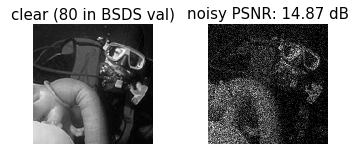

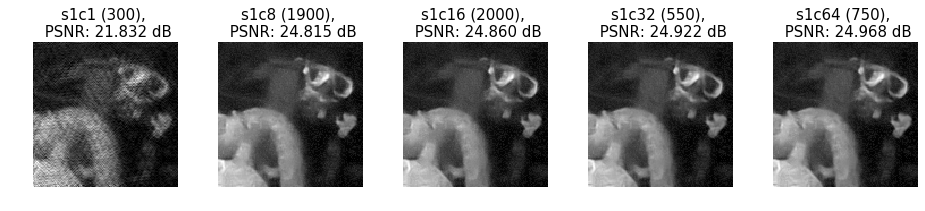

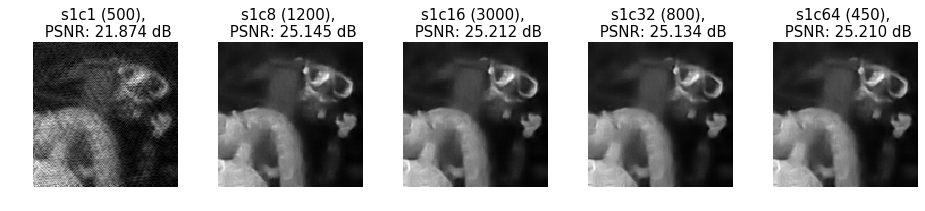

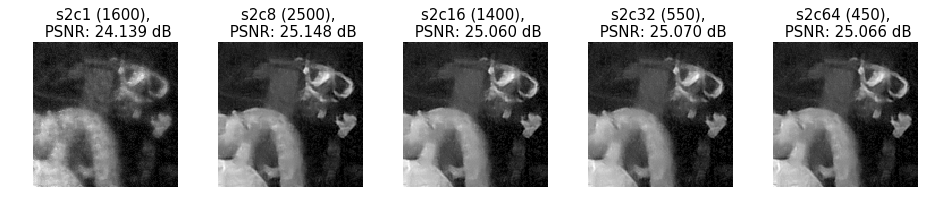

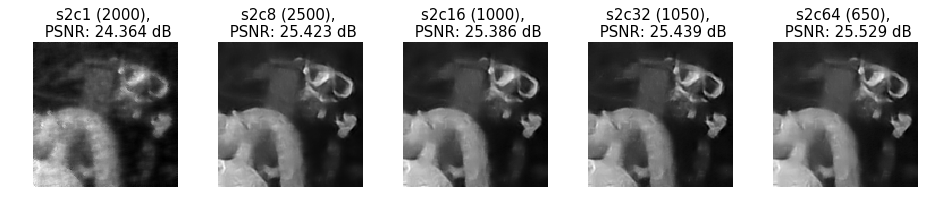

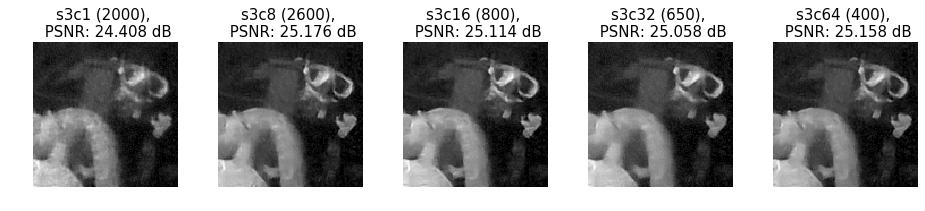

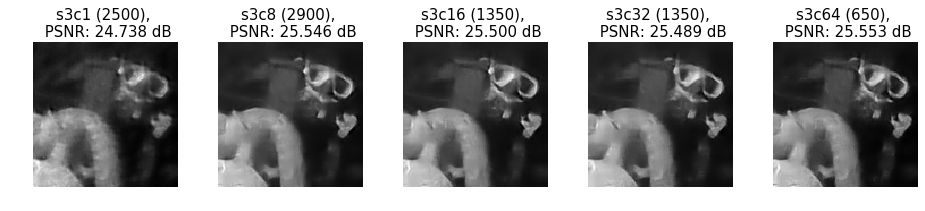

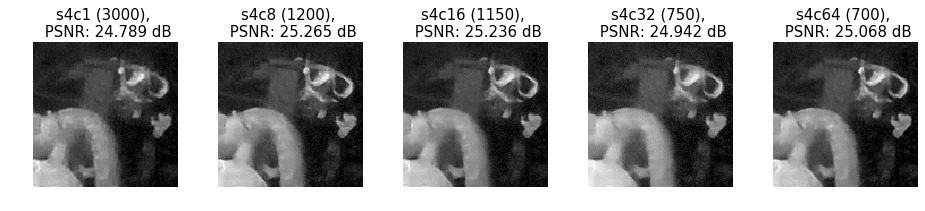

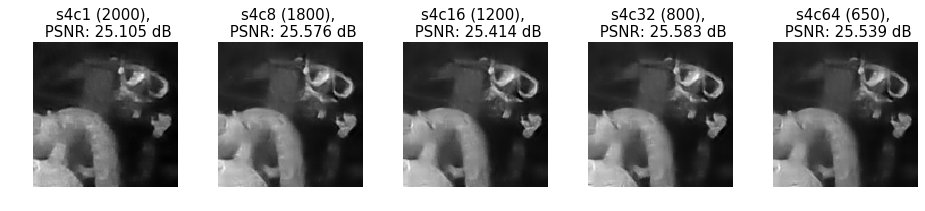

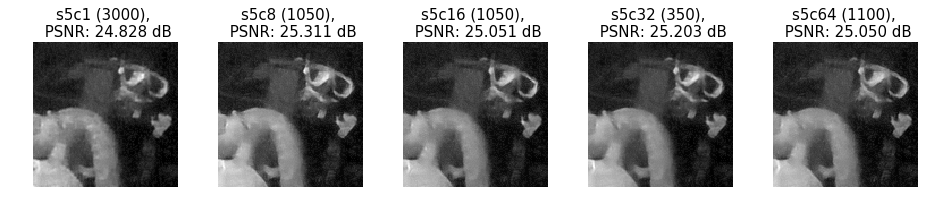

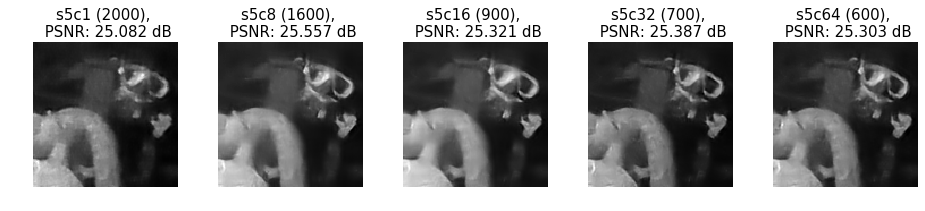

In [2]:
img_ind = 80
gt_pair, noisy_pair, dict_images_pois = prepare_dict_images(model_type='pois', img_ind=img_ind)
gt_pair, noisy_pair, dict_images_l2 = prepare_dict_images(model_type='l2', img_ind=img_ind)

### show all images

show([gt_pair['img'], noisy_pair['img']], \
     [gt_pair['title'], noisy_pair['title']], figsize=(5,5))

for s in [1,2,3,4,5]:
    images_batch_l2, images_batch_pois = [], []
    titles_batch_l2, titles_batch_pois = [], []
    for c in [1,8,16,32,64]:
        key = 's{}c{}'.format(s,c)
        images_batch_l2.append(dict_images_l2[key][0])
        titles_batch_l2.append(dict_images_l2[key][1])

        images_batch_pois.append(dict_images_pois[key][0])
        titles_batch_pois.append(dict_images_pois[key][1])
    show(images_batch_pois, titles_batch_pois)
    show(images_batch_l2, titles_batch_l2)
    
# plt.savefig('./comp_results_{}.png'.format(img_ind))

In [3]:
for img_ind in range(100):
    for model_type in ['pois', 'l2']:
        savefig_5x5_tests_l2_vs_pois_1600(img_ind, model_type)
        print(model_type, img_ind)

pois 0
l2 0
pois 1
l2 1
pois 2
l2 2
pois 3
l2 3
pois 4
l2 4
pois 5
l2 5
pois 6
l2 6
pois 7
l2 7
pois 8
l2 8
pois 9
l2 9
pois 10
l2 10
pois 11
l2 11
pois 12
l2 12
pois 13
l2 13
pois 14
l2 14
pois 15
l2 15
pois 16
l2 16
pois 17
l2 17
pois 18
l2 18
pois 19
l2 19
pois 20
l2 20
pois 21
l2 21
pois 22
l2 22
pois 23
l2 23
pois 24
l2 24
pois 25
l2 25
pois 26
l2 26
pois 27
l2 27
pois 28
l2 28
pois 29
l2 29
pois 30
l2 30
pois 31
l2 31
pois 32
l2 32
pois 33
l2 33
pois 34
l2 34
pois 35
l2 35
pois 36
l2 36
pois 37
l2 37
pois 38
l2 38
pois 39
l2 39
pois 40
l2 40
pois 41
l2 41
pois 42
l2 42
pois 43
l2 43
pois 44
l2 44
pois 45
l2 45
pois 46
l2 46
pois 47
l2 47
pois 48
l2 48
pois 49
l2 49
pois 50
l2 50
pois 51
l2 51
pois 52
l2 52
pois 53
l2 53
pois 54
l2 54
pois 55
l2 55
pois 56
l2 56
pois 57
l2 57
pois 58
l2 58
pois 59
l2 59
pois 60
l2 60
pois 61
l2 61
pois 62
l2 62
pois 63
l2 63
pois 64
l2 64
pois 65
l2 65
pois 66
l2 66
pois 67
l2 67
pois 68
l2 68
pois 69
l2 69
pois 70
l2 70
pois 71
l2 71
pois 72
l2 7

In [16]:
img_ind = 80
gt_pair, noisy_pair, dict_images_pois = prepare_dict_images(model_type='pois', img_ind=img_ind)
gt_pair, noisy_pair, dict_images_l2 = prepare_dict_images(model_type='l2', img_ind=img_ind)

# Compare poisloss with others

In [1]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from PoisDenoiser.utils import do_inference

% matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
s=4
c=32
saved_epoch = 1000
models_apps = {'pois':['', '_poisloss'], 'l2':['']}

from tqdm import tqdm

for img_ind in tqdm(range(100)):
    for model_type in models_apps:
        for app in models_apps[model_type]:
            
            model_name = model_type+'_1600'+app+'/'
            exp_name = model_name+'s{}c{}'.format(s,c)

            if app != '':
                app = app[1:]
            else:
                app = model_type
                
            do_inference(s,c,exp_name=exp_name, model_type=model_type,\
                       saved_epoch=saved_epoch, img_ind=img_ind, app=app, clear_ind=1)    
            
            plt.savefig('./results4report_compare_pois_poisloss_l2/num_1600/'+\
                        '{:03d}_{}.png'.format(int(img_ind), app))
            plt.close()
            

100%|██████████| 100/100 [01:54<00:00,  1.15s/it]
